<h1>Preparation and Overview</h1>
<h2>Preparation</h2>
The data preparation procedure we chose for this lab is similar to that of lab 1. We began with a mostly complete dataset, which has many features which are unnecessary for the classification task. We took the following steps to clean the data and prepare it for our use case: <br>
1. We first got rid of duplicate rows. We can reliably do this without a unique identifier because there are sufficiently many features to confidently say that exact duplicates of data are most likely a duplicate entry.<br>
2. We then removed any data with an unknown prediction class, whether the unknown class is due to the pitch being unidentifiable, or because the overview does not contain the translation from abreviated label to actual prediction class.<br>
3. Next, we removed outlier in the data. While this is not an exact science, we believe that the heuristic we used sufficiently cleans outliers out of the data without compromising the integrity of the data.<br>
4. Finally, we removed any data points where the ground truth cannot be 100% trusted. Our dataset included a measure of confidence in the label assigned to each data point. We removed any data points where the confidence was below a threshold of 1 (out of 2).<br>
<h2>Overview</h2>
This data is an interesting, yet unsurprising find. Baseball is one of the most statistics-driven professional sports in the world. Nearly every happening on the field is quantified and logged for further analysis. This logging is useful for both the clubs competing in a match, and also to the entities responsible for the broadcasts. Effortless data analytics can enhance a broadcast and help enhance the viewer's understanding of the game.<br>
With some preprocessing, broadcast networks can turn real-time images from the contest into data that a machine learning model can use to predict what sort of pitch was thrown. This information is useful for 2 main reasons. A casual fan trying to have a deeper understanding of the game can follow along more easily with a real-time indication of what's happening at a high level of the game. In kind, broadcasters and clubs can use this data to better understand trends in the opposition and their own clubs alike. While it is possible for a human to do this tedious work, automating it will cut down on mistakes, and allow real-time display, or real-time data analytics.

<h2>Class Variables</h2>

The dataset consists of 39 attributes and 15 prediction classes describing the information of the pitch thrown. Of these 39 attributes, we have chosen 5 attributes that are most likely candidates to use for the classification task. These are:

1. Break length - Float
2. Break angle - Float
3. Start Speed - Float
4. End Speed and - Float
5. Spin rate - Float

The prediction class is represented as a string object denoting the type of pitch - in classification we will turn this data into a series of binary one-vs-all data. <br>
We took a hierarchical approach towards the classification problem by clustering the prediction classes into three super classes, namely:

1. Fast pitches (FC – Cutter, FF – Four Seam Fastball, FS – Splitter, FT – Two Seam Fastball,SI – Sinker)
2. Breaking Balls ( CU – Curveball, KC – Knuckle Curve, KN – Knuckleball, SL – Slider, SC - Screwball)
3. Slow Pitches ( CH – Changeup, EP – Eephus, FO – Pitchout, PO – Pitchout, IN – Intentional Ball )

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

class MultiLayerPerceptronBase(object):
    def __init__(self, layer_widths=[20,3,3],
                 C=0.3, epochs=5000, eta=0.0001, random_state=None, activations="sigmoid",
                 objective="mse"):
        np.random.seed(random_state)
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.weights = []
        self.layer_widths=layer_widths
        self.activations=activations
        self.objective=objective
        self.activation_function = getattr(self, self.activations)
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""

        for idx, w in enumerate(self.layer_widths[:-1]):
            W_element_count = ((w + 1) * self.layer_widths[idx+1])
            W = np.random.uniform(-1,1, size = W_element_count)
            W.reshape((self.layer_widths[idx+1], -1))
            self.weights.append(W.reshape((self.layer_widths[idx+1], -1))) 

        # For Relu
        # https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb
        # Line 19
#         w = self.weights[0]
#         init_bound = np.sqrt(6. / (w.shape[0]*w.shape[1]))
#         w_0 = np.random.uniform(-init_bound, init_bound, size = w.shape)
#         w = w_0
#         w[:,:1] = 0
#         self.weights[0] = w

#         w = self.weights[-1]
#         init_bound = np.sqrt(0.5 / (w.shape[0]*w.shape[1]))
#         w_last = np.random.uniform(-init_bound, init_bound, size = w.shape)
#         w = w_last
#         w[:,:1] = 0
#         self.weights[-1] = w
#         for w in self.weights:
#              print(w.shape)
            
    @staticmethod
    def sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def relu(z):
        temp = np.maximum(0,z.copy())
        return temp  
    
    
    def silu(self,a):
        temp = a.copy()
        return (a*self.sigmoid(a)) 
    
    def _derive_activations(self, a, w, v, t="sigmoid"):

        if t == "sigmoid": 
            return (a*(1-a) * (w.T @ v))

        if t == "relu": 

            temp = a.copy()
            temp[temp<=0] = 0
            temp[temp>0] = 1

            return (temp*(w.T @ v))
    
        if t == "silu": 
            return (a + self.sigmoid(a)*(1-a)) * (w.T @ v)

    
    def _derive_objective(self, y, a, t="mse"):
        if t == "mse":
            return -2*(y-a)*a*(1-a)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    def _L2_reg(self, lambda_):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms    
        s = 0
        for w in self.weights:
            s += np.mean(w[:, 1:] **2)
        return (lambda_/len(self.weights)) * np.sqrt(s)
    
    def _cost(self,A,Y_enc):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A[-1])**2)
        L2_term = self._L2_reg(self.l2_C)
        return cost + L2_term

In [2]:
class MultiLayerPerceptron(MultiLayerPerceptronBase):
    def _feedforward(self, X):
        Z = []
        A = []
        x = X.copy()
        for idx, w in enumerate(self.weights):
            if idx != 0:
                a_l = self.activation_function(Z[-1])
                a_l = self._add_bias_unit(a_l, how = "row")
            else:
                a_l = self._add_bias_unit(x.T, how="row")
            A.append(a_l)
            z_l = w @ a_l
            Z.append(z_l)
        a_l = self.sigmoid(Z[-1])
        A.append(a_l)
        return A, Z
    
    def _get_gradient(self, A, y_enc):
        gradients = []
        V = []
        for idx in range(len(self.weights), 0, -1):
            if idx == len(self.weights):
#                 v_l = -2 * (y_enc - A[idx]) * A[idx]*(1-A[idx])
                v_l = self._derive_objective(y_enc, A[idx], self.objective)
                V.append(v_l)
                
                grad = v_l @ A[idx-1].T
                grad[:, 1:] += self.weights[idx-1][:, 1:] * self.l2_C
                gradients.append(grad)
            else:
                v_l = A[idx]*(1-A[idx])*(self.weights[idx].T @ V[-1])
                v_l = self._derive_activations(A[idx], self.weights[idx],
                                               V[-1], self.activations)
                V.append(v_l[1:, :])
                
                grad = v_l[1:, :] @ A[idx-1].T
                
                grad[:, 1:] += self.weights[idx-1][:, 1:] * self.l2_C
                gradients.append(grad)
        return list(reversed(gradients))
    
    def predict(self, X):
        A, _ = self._feedforward(X)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred
    def fit(self, X, y, print_progress = False):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        #init weights and set up matrices
        self._initialize_weights()
        
        self.cost = []
        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
                
            A, Z = self._feedforward(X)
            
            cost = self._cost(A[-1], Y_enc)
            self.cost.append(cost)
            
            grads = self._get_gradient(A, Y_enc)
            
            for w, g in zip(self.weights, grads):
                w -= self.eta * g
        return self

In [3]:
# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
X = ds.data/16.0-0.5
y = ds.target

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]


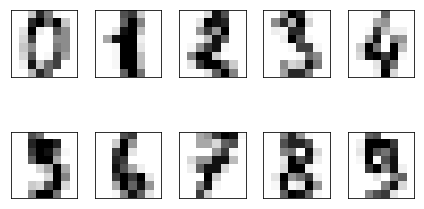

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

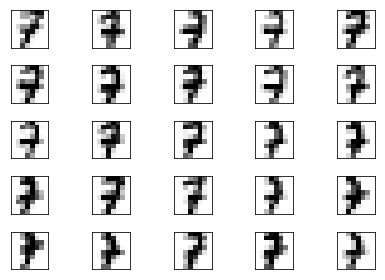

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
digit = 7
x_digits = X[y == digit]
for i in range(25):
    img = x_digits[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1437, 64)
(1437,)
(360, 64)
(360,)


In [7]:
import sys
nn = MultiLayerPerceptron([64, 50, 10], 0.3, 500, 0.001, None)
nn.fit(X_train, y_train, print_progress=False)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))

Test acc: 0.9416666666666667


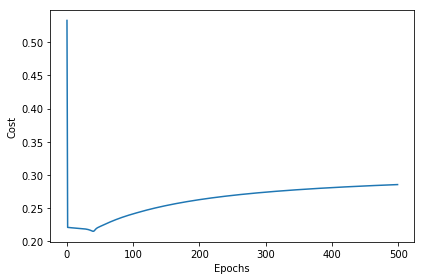

In [8]:
plt.plot(range(len(nn.cost)), nn.cost)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()


In [9]:
import pandas as pd
import numpy as np
df = pd.read_csv('../pitches.csv')

In [10]:
#drop unkown prediction classes and prediction classes with no definition from data source
df.drop_duplicates(inplace=True)
df = df[df.pitch_type != 'UN']
df = df[df.pitch_type != 'FA']

features = ['break_angle', 'break_length', 'end_speed', 'start_speed', 'spin_rate']
#remove wild pitches or intentional walks as break length outliers. Code sourced from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
for feature in features:
    if feature != 'pitch_type':
        df = df[np.abs(df[feature]-df[feature].mean()) <= (12*df[feature].std())]

#drop data points where prediction class is unreliable
df = df[df.type_confidence >= 1.0]

#Drop any data with incomplete records
df.dropna(inplace=True)

In [11]:
#separate pitches based on prediction class for visualization
# What might be a reasonable value for bounding break_length ? I picked 100.0
df = df[df.break_length <= 100.0] 
fast_pitches_super_group = df[df.pitch_type.isin(['FC','FF','FS','FT','SI'])]
fast_pitches_super_group['grouping'] = 'fast_ball'
breaking_pitches_super_group = df[df.pitch_type.isin(['CU', 'KC', 'KN', 'SL', 'SC'])]
breaking_pitches_super_group['grouping'] = 'breaking_ball'
slow_pitches_super_group = df[df.pitch_type.isin(['CH','EP','FO','PO','IN'])]
slow_pitches_super_group['grouping'] = 'slow_ball'
visualization_frames = [fast_pitches_super_group, breaking_pitches_super_group, slow_pitches_super_group]
result = pd.concat(visualization_frames)


/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [12]:
X = result[features]
y = result['grouping']

for f in features:
    col = X[f]
    col -= min(col)
    col /= (max(col) - min(col))
y[y == "breaking_ball"] = 1
y[y == "fast_ball"] = 2
y[y == "slow_ball"] = 0

y = y.values.astype(np.int)
X = X.values.astype(np.int)
print(X, y)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 ...
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]] [2 2 2 ... 0 0 0]


/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/rasimon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.8)



def weighted_accuracy(y_test, yhat):
    percents = {}
    weights = []
    for label in range(0,3):
        percents[label] = len(y_test[y_test==label]) / len(y_test)
    for label in y_test:
        weights.append(percents[label])
    return accuracy_score(y_test,yhat,sample_weight=weights)

In [40]:
nn = MultiLayerPerceptron([X_train.shape[1], 20, 3], 0.2, 40, .001, None, "sigmoid")
nn.fit(X_train, y_train, print_progress=True)
yhat = nn.predict(X_test)
print('Test acc:',weighted_accuracy(y_test,yhat))

Epoch: 40/40

Test acc: 0.8208254777317004


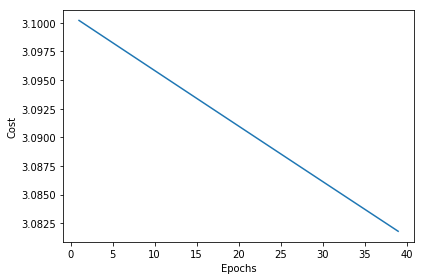

In [41]:
plt.plot(range(1,len(nn.cost)), nn.cost[1:])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()


In [180]:
import random
activations = []
C = []
iterations = []
eta = []
accuracy = []
h_layers = []
for idx in range(100):  
    act = ["sigmoid", "relu", "silu"]
    act = act[int(random.uniform(0,2))]
    c = random.uniform(0.1, 0.9)
    it = int(random.uniform(5, 100))
    e = random.uniform(0.0001, 0.1)
    h_layer = int(random.uniform(5, 50))
    
    nn = MultiLayerPerceptron([X_train.shape[1], h_layer, 3], c, it, e, None, act)
    activations.append(act)
    iterations.append(it)
    C.append(c)
    eta.append(e)
    iterations.append(it)
    h_layers.append(h_layer)
    nn.fit(X_train, y_train, print_progress=False)
    yhat = nn.predict(X_test)
    accuracy.append(weighted_accuracy(y_test,yhat))
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Violin Plot of Accuracy


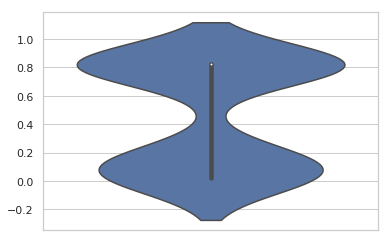

In [181]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(y=accuracy, title="Accuracy")
print("Violin Plot of Accuracy")

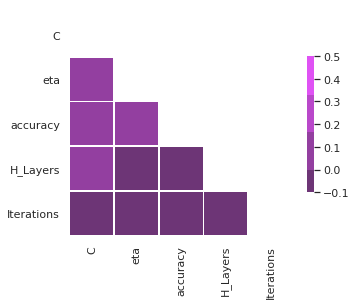

In [182]:

columns = ["C", "eta", "accuracy","H_Layers","Iterations"]
correlation_df = pd.DataFrame(columns=columns)

for c,e,a,h,i in zip(C, eta, accuracy, h_layers, iterations):
    df = pd.DataFrame(np.array([c,e,a,h,i]).reshape(1,5), columns=columns)
    correlation_df = correlation_df.append(df, ignore_index=True)
corr = correlation_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(5,5))

cmap = sns.dark_palette((300,90,60), input = "husl")

sns.heatmap(corr, mask=mask, cmap = cmap, vmax = .5, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink":.5})

In [183]:
idx = accuracy.index(max(accuracy))
a,c,e,a_,h,i = activations[idx],C[idx],eta[idx],accuracy[idx],h_layers[idx],iterations[idx]

In [186]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3
                      , shuffle=True)
skf.get_n_splits(X,y)
accs = []
for train_idx, test_idx in skf.split(X,y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    nn = MultiLayerPerceptron([X_train.shape[1], h, 3], c, i, e, None, a)
    nn.fit(X_train, y_train)
    yhat = nn.predict(X_test)
    accs.append(weighted_accuracy(y_test,yhat))
    print("Validation Acc:",weighted_accuracy(y_test,yhat))
print(sum(accs)/len(accs))

Validation Acc: 0.8205519610928914
Validation Acc: 0.8205525954326225
Validation Acc: 0.8205534192856239
0.8205526586037126
